# **Pure MCTS**

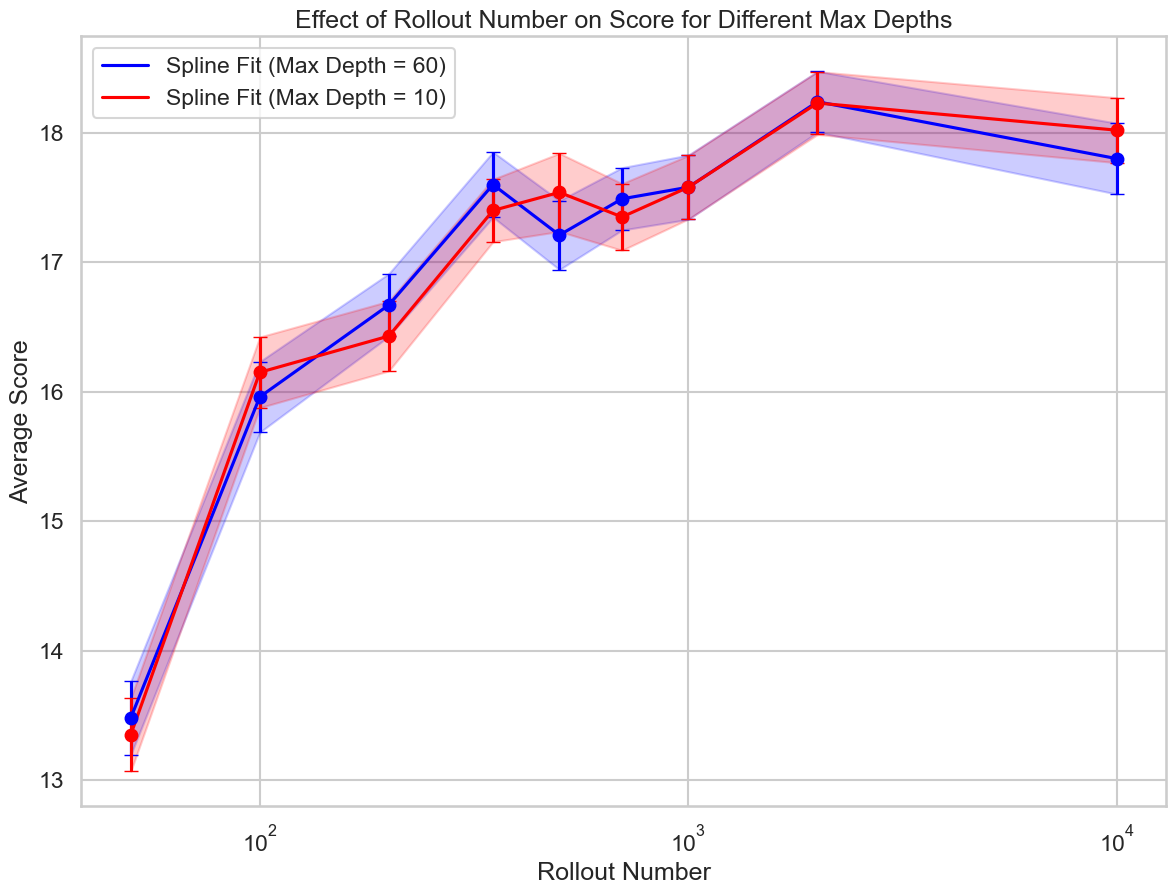

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn as sns

# Data
rollout_numbers = np.array([50, 100, 200, 350, 500, 700, 1000, 2000, 10000])

average_scores_60 = np.array([13.48, 15.96, 16.67, 17.6, 17.21, 17.49, 17.58, 18.24, 17.8])
std_errors_60 = np.array([0.2837, 0.2727, 0.2421, 0.2519 ,0.2666, 0.2410, 0.2483, 0.2350, 0.2739])

average_scores_10 = np.array([13.35, 16.15, 16.43, 17.4, 17.54, 17.35, 17.58, 18.23, 18.02])
std_errors_10 = np.array([0.2819, 0.2729, 0.2692, 0.2412, 0.3018, 0.2574, 0.2454, 0.2428, 0.2510])

# Interpolation in log space
log_rollout_numbers = np.log(rollout_numbers)
log_rollout_numbers_fine = np.linspace(log_rollout_numbers.min(), log_rollout_numbers.max(), 500)
rollout_numbers_fine = np.exp(log_rollout_numbers_fine)

# Interpolate average scores
spl_60 = make_interp_spline(log_rollout_numbers, average_scores_60, k=1)
average_scores_60_smooth = spl_60(log_rollout_numbers_fine)

spl_10 = make_interp_spline(log_rollout_numbers, average_scores_10, k=1)
average_scores_10_smooth = spl_10(log_rollout_numbers_fine)

# Compute upper and lower bounds for standard error
upper_60 = average_scores_60 + std_errors_60
lower_60 = average_scores_60 - std_errors_60

upper_10 = average_scores_10 + std_errors_10
lower_10 = average_scores_10 - std_errors_10

# Interpolate upper and lower bounds
spl_upper_60 = make_interp_spline(log_rollout_numbers, upper_60, k=1)
spl_lower_60 = make_interp_spline(log_rollout_numbers, lower_60, k=1)
upper_60_smooth = spl_upper_60(log_rollout_numbers_fine)
lower_60_smooth = spl_lower_60(log_rollout_numbers_fine)

spl_upper_10 = make_interp_spline(log_rollout_numbers, upper_10, k=1)
spl_lower_10 = make_interp_spline(log_rollout_numbers, lower_10, k=1)
upper_10_smooth = spl_upper_10(log_rollout_numbers_fine)
lower_10_smooth = spl_lower_10(log_rollout_numbers_fine)

# Plotting
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(14,10))

# Plot the data points with error bars
plt.errorbar(rollout_numbers, average_scores_60, yerr=std_errors_60, fmt='o', capsize=5, color='blue')
plt.errorbar(rollout_numbers, average_scores_10, yerr=std_errors_10, fmt='o', capsize=5, color='red')

# Plot the interpolated lines
plt.plot(rollout_numbers_fine, average_scores_60_smooth, label='Spline Fit (Max Depth = 60)', color='blue')
plt.plot(rollout_numbers_fine, average_scores_10_smooth, label='Spline Fit (Max Depth = 10)', color='red')

# Fill between upper and lower bounds to represent standard error
plt.fill_between(rollout_numbers_fine, lower_60_smooth, upper_60_smooth, alpha=0.2, color='blue')
plt.fill_between(rollout_numbers_fine, lower_10_smooth, upper_10_smooth, alpha=0.2, color='red')

# Customize the plot
plt.xscale('log')
plt.xlabel('Rollout Number')
plt.ylabel('Average Score')
plt.title('Effect of Rollout Number on Score for Different Max Depths')
plt.legend()
plt.show()

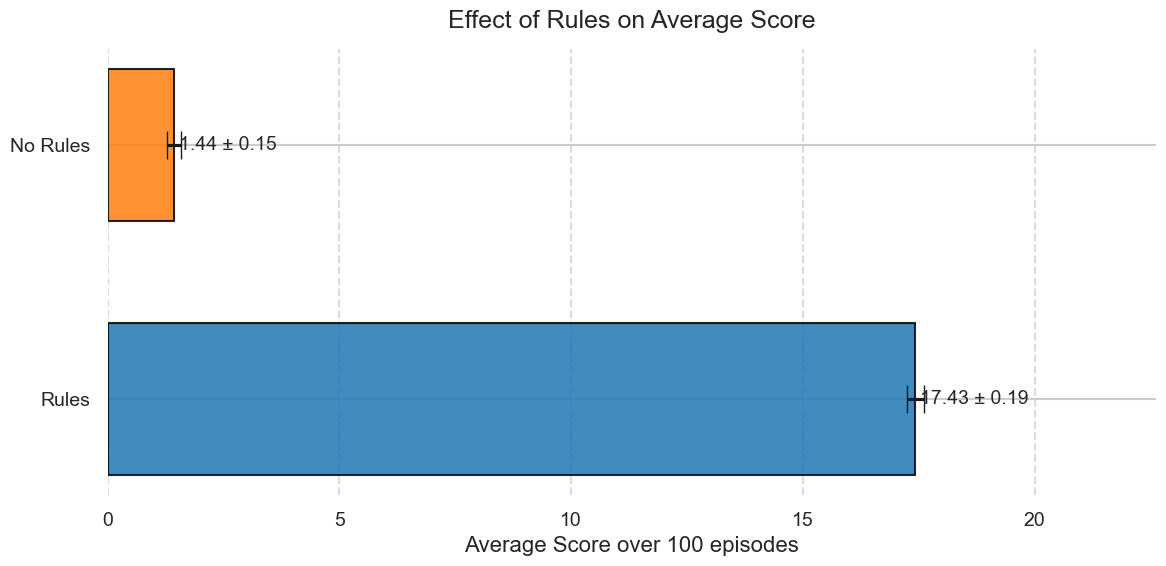

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data
values = [17.43, 1.44]
std_errors = [0.19, 0.15]
labels = ['Rules', 'No Rules']

# Set up the figure and axes
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(12, 6))

# Create a horizontal bar plot
bars = plt.barh(labels, values, xerr=std_errors, capsize=10, height=0.6,
                color=['#1f77b4', '#ff7f0e'], alpha=0.85, edgecolor='black')

# Add annotations for the values and standard errors
for bar, value, err in zip(bars, values, std_errors):
    width = bar.get_width()
    plt.text(width + max(std_errors)*0.5, bar.get_y() + bar.get_height()/2,
             f'{value:.2f} ± {err:.2f}', va='center', fontsize=14)

# Customize the plot aesthetics
plt.xlabel('Average Score over 100 episodes', fontsize=16)
plt.title('Effect of Rules on Average Score', fontsize=18, pad=15)
plt.xlim(0, values[0] + std_errors[0] + 5)

# Remove spines and ticks for a cleaner look
sns.despine(left=True, bottom=True)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Add subtle grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# **AlphaZero**

Found 40 MCTS searches in the log.


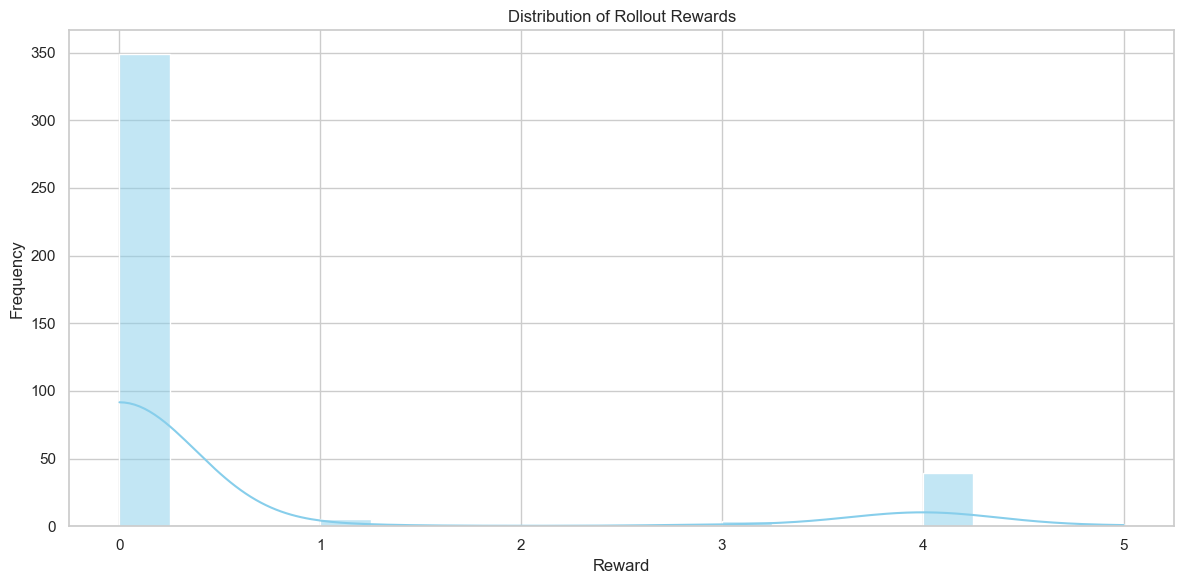

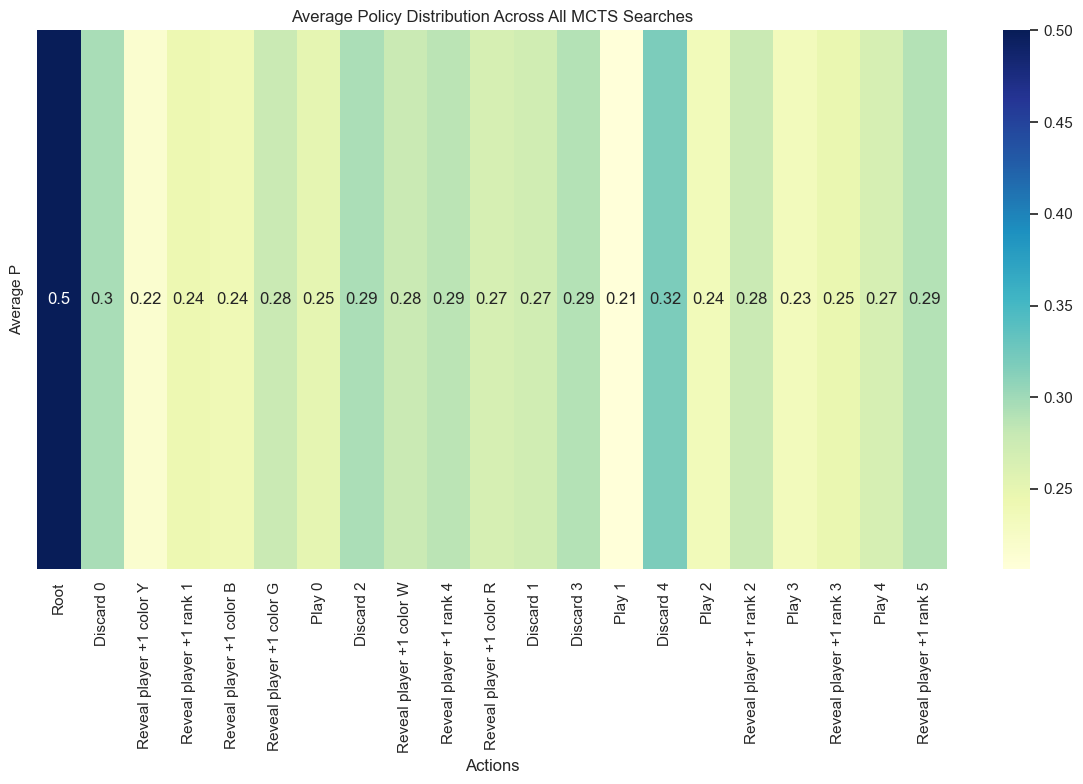

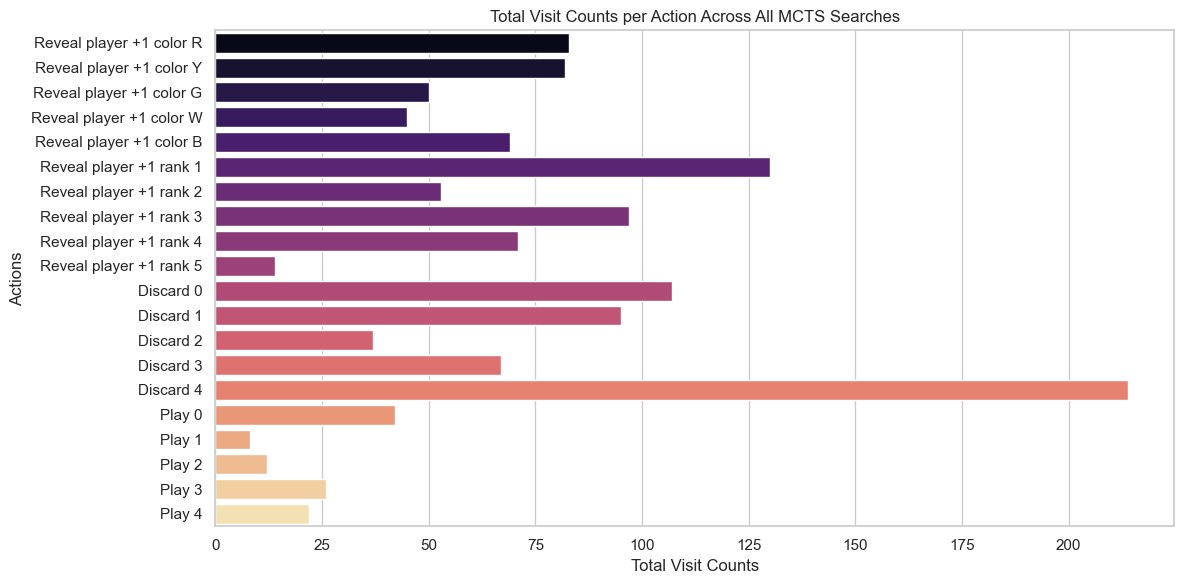

In [21]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import pandas as pd
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def get_parent_node(node_str):
    """
    Given a node string, return its parent node string.
    """
    if node_str == '()':
        return None
    # Remove the last move
    parent_str = re.sub(r'\(.*?\)$', '', node_str)
    # Ensure it's properly closed
    parent_str = parent_str.strip()
    if not parent_str.endswith(')'):
        parent_str += ')'
    return parent_str if parent_str else '()'


def extract_move(node_str):
    """
    Extract the move description from a node string.
    Handles cases where actions are sometimes enclosed in parentheses and sometimes not.
    Example:
        '((Discard 0), (Reveal player +1 color Y))' -> 'Reveal player +1 color Y'
        '(Discard 4' -> 'Discard 4'
    """
    # Find all moves within the parentheses
    moves = re.findall(r'\(([^)]+)\)', node_str)
    if moves:
        last_move = moves[-1].strip()
    else:
        # If no parentheses, attempt to extract the last word segment
        parts = node_str.split(',')
        last_move = parts[-1].strip().strip('()').strip()
    
    # Normalize the move by stripping any remaining parentheses and whitespace
    last_move = last_move.strip('()').strip()
    return last_move if last_move else 'Root'


def parse_log_file(log_file_path):
    """
    Parse the log file and extract MCTS trees.
    Returns a list of trees, each represented as a networkx DiGraph with node attributes.
    Ensures that every node has 'move', 'P', 'Q', 'N', and 'V_norm' attributes.
    """
    with open(log_file_path, 'r') as file:
        lines = file.readlines()

    mcts_searches = []
    current_search = None
    in_search = False
    current_rollout = None

    # Initialize a regex pattern to capture key log messages
    patterns = {
        'start_search': re.compile(r'=== Starting MCTS Search ==='),
        'end_search': re.compile(r'=== MCTS Search Completed ==='),
        'rollout_start': re.compile(r'--- Rollout #(\d+) ---'),
        'traversing_path': re.compile(r'Traversing Path: \[(.*?)\]'),
        'added_child': re.compile(r'Added Child Node: (\(.*?\)) \| P=([0-9.]+)'),
        'simulating_node': re.compile(r'Simulating Node: (\(.*?\)) \| Value: ([\-0-9.]+)'),
        'backpropagate': re.compile(r'Backpropagating reward: ([\-0-9.]+)'),
        'best_node': re.compile(r'Best node chosen by MCTS: (\(.*?\)) \| Visit Count: (\d+)'),
        'chosen_action': re.compile(r'Chosen Action: \((.*?)\) \| Visit Count: (\d+)'),
    }

    # Initialize variables to track the current MCTS search
    for line_num, line in enumerate(lines, 1):
        line = line.strip()
        # Check for start of MCTS search
        if patterns['start_search'].search(line):
            in_search = True
            current_search = {
                'tree': nx.DiGraph(),
                'rollouts': [],
                'chosen_action': None,
                'best_node': None
            }
            # Add root node with default attributes
            current_search['tree'].add_node('()', move='Root', P=1.0, Q=0.0, N=0, V_norm=0.0)
            continue

        # Check for end of MCTS search
        if patterns['end_search'].search(line):
            if current_search:
                mcts_searches.append(current_search)
                current_search = None
            in_search = False
            continue

        if in_search and current_search:
            # Check for rollout start
            rollout_match = patterns['rollout_start'].search(line)
            if rollout_match:
                rollout_num = int(rollout_match.group(1))
                current_rollout = {
                    'rollout_num': rollout_num,
                    'path': [],
                    'added_children': [],
                    'simulated_node': None,
                    'simulated_value': None,
                    'reward': None
                }
                current_search['rollouts'].append(current_rollout)
                continue

            # Check for traversing path
            traversing_match = patterns['traversing_path'].search(line)
            if traversing_match and current_rollout:
                path_str = traversing_match.group(1)
                # Split the path string into individual node strings
                # Handle empty paths
                if path_str.strip() == '':
                    path = []
                else:
                    # Use a regex to correctly split the node strings
                    path = re.findall(r'\(.*?\)', path_str)
                current_rollout['path'] = path

                # Ensure all nodes in the path are added to the tree with 'move' attribute
                for node in path:
                    if not current_search['tree'].has_node(node):
                        move = extract_move(node)
                        current_search['tree'].add_node(node, move=move, P=0.0, Q=0.0, N=0, V_norm=0.0)
                continue

            # Check for added child nodes
            added_child_match = patterns['added_child'].search(line)
            if added_child_match and current_rollout:
                child_node = added_child_match.group(1)
                P = float(added_child_match.group(2))
                current_rollout['added_children'].append((child_node, P))
                # Determine parent node
                parent_node = get_parent_node(child_node)
                if parent_node:
                    # Extract move
                    move = extract_move(child_node)
                    # Add parent node if not present
                    if not current_search['tree'].has_node(parent_node):
                        parent_move = extract_move(parent_node)
                        current_search['tree'].add_node(parent_node, move=parent_move, P=0.0, Q=0.0, N=0, V_norm=0.0)
                    # Add child node to the tree with attributes
                    if not current_search['tree'].has_node(child_node):
                        current_search['tree'].add_node(child_node, move=move, P=P, Q=0.0, N=0, V_norm=0.0)
                    # Add edge from parent to child
                    current_search['tree'].add_edge(parent_node, child_node)
                else:
                    print(f"Warning: Parent node not found for child node '{child_node}' at line {line_num}.")
                continue

            # Check for simulating node
            simulating_match = patterns['simulating_node'].search(line)
            if simulating_match and current_rollout:
                sim_node = simulating_match.group(1)
                sim_value = float(simulating_match.group(2))
                current_rollout['simulated_node'] = sim_node
                current_rollout['simulated_value'] = sim_value
                # Assign value to the node
                if current_search['tree'].has_node(sim_node):
                    current_search['tree'].nodes[sim_node]['Q'] += sim_value
                    current_search['tree'].nodes[sim_node]['N'] += 1
                else:
                    # If the node wasn't added via 'added_child', add it now
                    move = extract_move(sim_node)
                    current_search['tree'].add_node(sim_node, move=move, P=0.0, Q=sim_value, N=1, V_norm=0.0)
                continue

            # Check for backpropagation
            backprop_match = patterns['backpropagate'].search(line)
            if backprop_match and current_rollout:
                reward = float(backprop_match.group(1))
                current_rollout['reward'] = reward
                # Update Q and N for all nodes in the path
                for node in current_rollout['path']:
                    if current_search['tree'].has_node(node):
                        current_search['tree'].nodes[node]['Q'] += reward
                        current_search['tree'].nodes[node]['N'] += 1
                        # Update normalized value (assuming Q ranges between -1 to 1 for normalization)
                        current_search['tree'].nodes[node]['V_norm'] = min(max((current_search['tree'].nodes[node]['Q'] + 1) / 2, 0.0), 1.0)
                continue

            # Check for best node
            best_node_match = patterns['best_node'].search(line)
            if best_node_match and current_search:
                best_node = best_node_match.group(1)
                best_N = int(best_node_match.group(2))
                current_search['best_node'] = best_node
                # Optionally, you can store best_N if needed
                continue

            # Check for chosen action
            chosen_action_match = patterns['chosen_action'].search(line)
            if chosen_action_match and current_search:
                action = chosen_action_match.group(1)
                action_N = int(chosen_action_match.group(2))
                # Normalize the action string
                action = extract_move(action)
                current_search['chosen_action'] = (action, action_N)
                continue

    return mcts_searches


def plot_rollout_rewards(mcts_searches):
    """
    Plot a histogram with KDE showing the distribution of rewards across all rollouts.
    """
    rewards = []
    for search in mcts_searches:
        for rollout in search['rollouts']:
            if rollout['reward'] is not None:
                rewards.append(rollout['reward'])

    plt.figure(figsize=(12, 6))
    sns.histplot(rewards, bins=20, kde=True, color='skyblue')
    plt.title('Distribution of Rollout Rewards')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


def plot_policy_distribution(mcts_searches):
    """
    Plot a heatmap showing the average policy distribution over all searches.
    """
    policy_counter = defaultdict(float)
    total_p = defaultdict(float)

    for search in mcts_searches:
        tree = search['tree']
        for node in tree.nodes(data=True):
            P = node[1].get('P', 0.0)
            move = node[1].get('move', 'No Move')
            policy_counter[move] += P
            total_p[move] += 1

    # Calculate average policy
    avg_policy = {move: (policy_counter[move] / total_p[move] if total_p[move] > 0 else 0.0) for move in policy_counter}

    # Convert to DataFrame for seaborn
    df_policy = pd.DataFrame(list(avg_policy.items()), columns=['Action', 'Average P'])

    plt.figure(figsize=(12, 8))
    sns.heatmap(df_policy.set_index('Action').T, annot=True, cmap='YlGnBu')
    plt.title('Average Policy Distribution Across All MCTS Searches')
    plt.xlabel('Actions')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


def plot_visit_counts(mcts_searches):
    """
    Plot a bar chart showing total visit counts for each action across all MCTS searches.
    """
    # Define the specific order of actions
    action_order = [
        "Reveal player +1 color R", "Reveal player +1 color Y", "Reveal player +1 color G", 
        "Reveal player +1 color W", "Reveal player +1 color B", "Reveal player +1 rank 1", 
        "Reveal player +1 rank 2", "Reveal player +1 rank 3", "Reveal player +1 rank 4", 
        "Reveal player +1 rank 5", "Discard 0", "Discard 1", "Discard 2", "Discard 3", 
        "Discard 4", "Play 0", "Play 1", "Play 2", "Play 3", "Play 4"
    ]

    # Initialize a visit counter
    visit_counter = defaultdict(int)

    # Count visits for each move
    for search in mcts_searches:
        tree = search['tree']
        for node in tree.nodes(data=True):
            move = node[1].get('move', 'No Move')
            N = node[1].get('N', 0)
            visit_counter[move] += N

    # Reorganize the actions and counts in the desired order
    actions = []
    counts = []

    for action in action_order:
        if action in visit_counter:
            actions.append(action)
            counts.append(visit_counter[action])
        else:
            actions.append(action)
            counts.append(0)  # If no visits, set count to 0

    # Plot the bar chart with actions in the specific order
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts, y=actions, palette='magma')
    plt.title('Total Visit Counts per Action Across All MCTS Searches')
    plt.xlabel('Total Visit Counts')
    plt.ylabel('Actions')
    plt.tight_layout()
    plt.show()


def visualize_summary(mcts_searches):
    """
    Generate summary visualizations including action frequency, rollout rewards, policy distribution, and visit counts.
    """
    plot_rollout_rewards(mcts_searches)
    plot_policy_distribution(mcts_searches)
    plot_visit_counts(mcts_searches)

# ---------------------- Execution Section ----------------------
if __name__ == "__main__":
    # Path to your log file
    log_file_path = '../agent_logs/agent_one_20241022_165932.log'

    # Check if the log file exists
    if not os.path.exists(log_file_path):
        print(f"Log file '{log_file_path}' does not exist. Please check the path and filename.")
    else:
        # Parse the log file
        mcts_searches = parse_log_file(log_file_path)
        print(f"Found {len(mcts_searches)} MCTS searches in the log.")

        # Visualize summary statistics
        visualize_summary(mcts_searches)

Found 39 MCTS searches in the log.


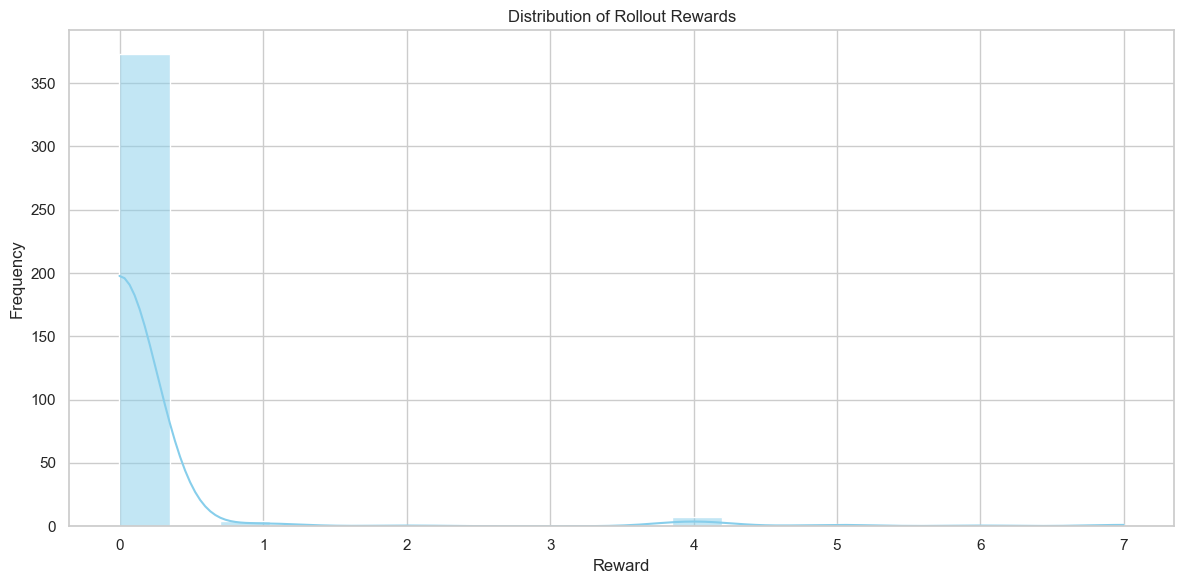

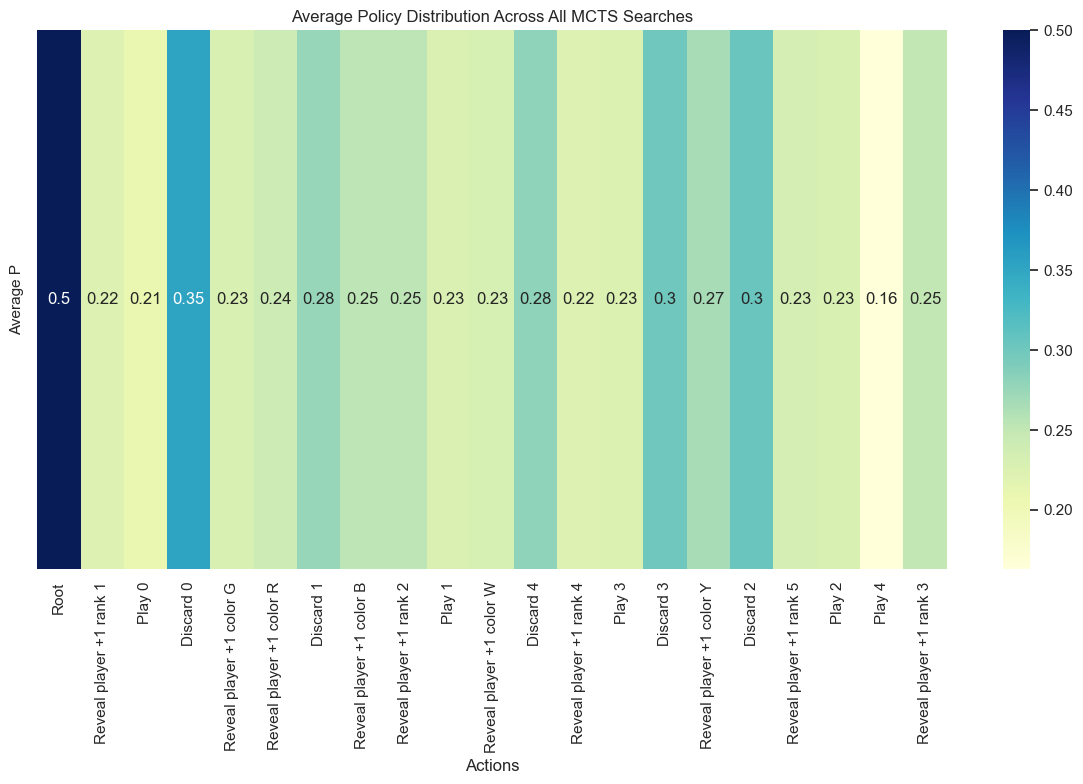

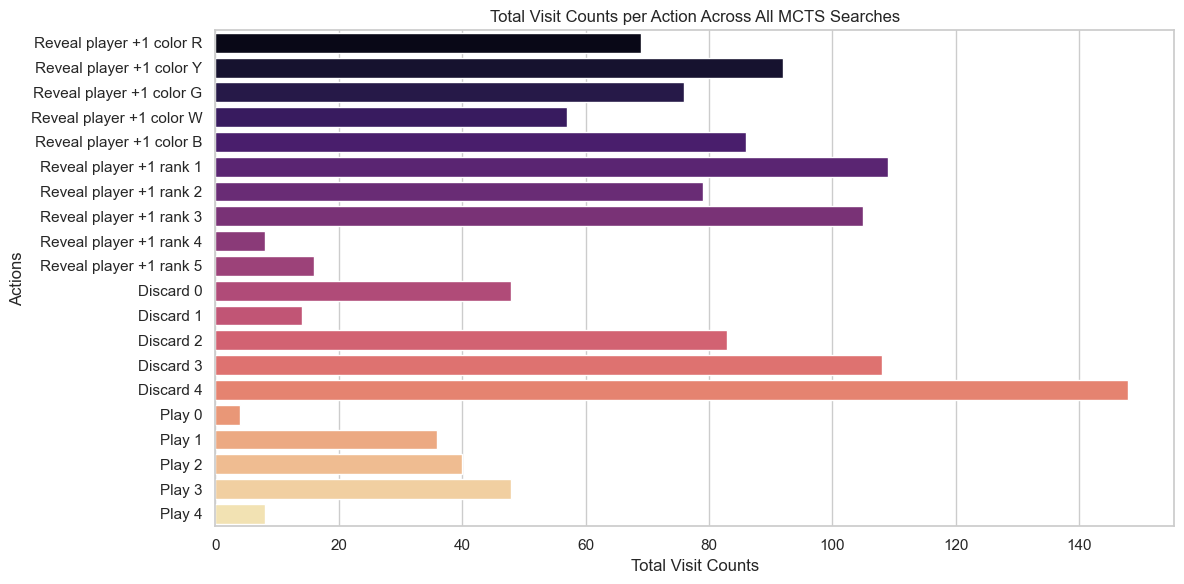

In [23]:
# ---------------------- Execution Section ----------------------
if __name__ == "__main__":
    # Path to your log file
    #log_file_path = '../agent_logs/agent_one_20241022_165932.log'
    log_file_path = "../agent_logs/agent_one_20241023_110349.log"

    # Check if the log file exists
    if not os.path.exists(log_file_path):
        print(f"Log file '{log_file_path}' does not exist. Please check the path and filename.")
    else:
        # Parse the log file
        mcts_searches = parse_log_file(log_file_path)
        print(f"Found {len(mcts_searches)} MCTS searches in the log.")

        # Visualize summary statistics
        visualize_summary(mcts_searches)